In [1]:
import glob
import time

# Divide up into cars and notcars
images = glob.glob('data/**/*.png', recursive=True)
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

In [2]:
print(len(cars), len(notcars))

8792 8968


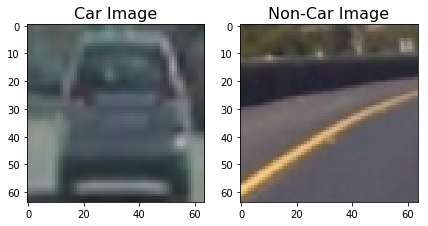

In [27]:
import cv2
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
%matplotlib inline

car_img = mpimg.imread(cars[5])
noncar_img = mpimg.imread(notcars[5])

# Visualize 
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)

ax2.imshow(noncar_img)
ax2.set_title('Non-Car Image', fontsize=16)

In [5]:

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:, :, 0], size).ravel()
    color2 = cv2.resize(img[:, :, 1], size).ravel()
    color3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((color1, color2, color3))


def color_hist(img, nbins=32):
    ''' Compute the histogram of the color channels.
    '''
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    return hist_features


def get_hog_features(img, orient, pix_per_cell,
                     cell_per_block, vis=False,
                     feature_vec=True):
    '''Extract HOG features.
    '''
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, color_space='YCrCb', spatial_size=(32, 32), hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True,
                     hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)

        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat is True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat is True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat is True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


def find_cars(img, ystart, ystop, scale,
              svc, X_scaler, color_space,
              orient, pix_per_cell,
              cell_per_block, hog_channel,
              spatial_size,
              hist_bins, all_rectangles=False):
    '''Extracts features from image and trains SVM model on those features.
    '''
    counts = 0
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2' + color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient * cell_per_block ** 2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog1 = get_hog_features(hog_channel, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            
            test_prediction = svc.predict(test_features)

            if test_prediction == 1 or all_rectangles:
                counts = counts + 1
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                #cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                #              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)
                rectangles.append(((xbox_left, ytop_draw + ystart),
                                   (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

    return rectangles

### Visualize HOG features

C:\Users\Vinay\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


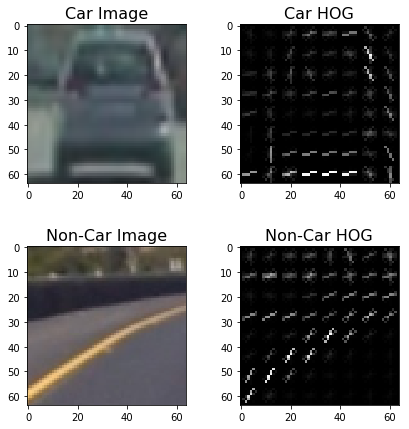

In [6]:
car_img = mpimg.imread(cars[5])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(notcars[5])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

### Feature extraction for model

In [7]:
color_space='YCrCb'
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel='ALL'
spatial_feat=True
hist_feat=True
hog_feat=True

car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

C:\Users\Vinay\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Split dataset into test and train and train the model

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Scale X and split into test and train set
scaled_X = StandardScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify =y)


In [9]:
from sklearn.svm import LinearSVC

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

9.31 Seconds to train SVC...


In [10]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9932
My SVC predicts:  [ 1.  1.  1.  0.  1.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  1.  0.  1.  0.  0.  1.  0.  0.]
0.00199 Seconds to predict 10 labels with SVC


### Find window with car

In [11]:
img = mpimg.imread('test_images/test6.jpg')

color_space='YCrCb'
ystart = 400
ystop = 656
scale = 1.5
X_scale_funct = StandardScaler().fit(X)
car_windows = find_cars(img, ystart, ystop, scale, svc,
                        X_scale_funct, color_space, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins)
print(len(car_windows))

C:\Users\Vinay\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


14


### Save the model

In [12]:
import pickle

data={
    'svc': svc,
    'X_scaler': X_scale_funct,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }

with open('model-params.pk', 'wb') as pFile:
    pickle.dump(data, pFile)


In [13]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Plot car boxes

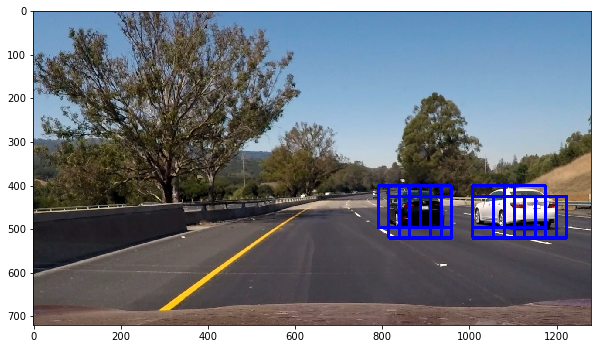

In [14]:
test_img_rects = draw_boxes(img, car_windows)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Show all potential search areas

C:\Users\Vinay\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of boxes:  304


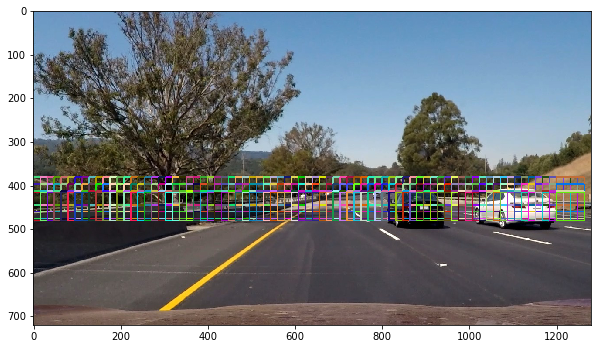

In [15]:
rects = []

ystart = 380
ystop = 500
scale = 1.0
rects.append(find_cars(img, ystart, ystop, scale, svc,
                        X_scale_funct, color_space, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins, all_rectangles=True))
ystart = 416
ystop = 500
scale = 1.0
rects.append(find_cars(img, ystart, ystop, scale, svc,
                        X_scale_funct, color_space, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins, all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist]
#print(len(rectangles))
test_img_rects = draw_boxes(img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

C:\Users\Vinay\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of boxes:  224


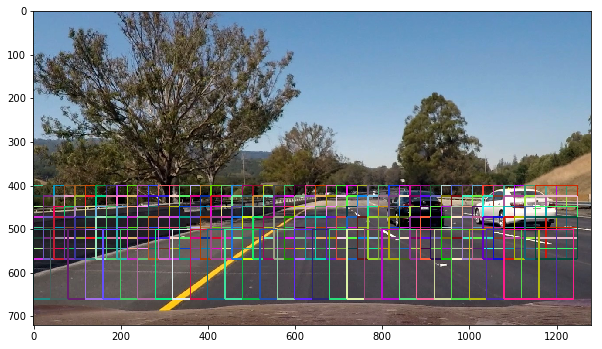

In [16]:
rects = []

ystart = 400
ystop = 600
scale = 1.5
rects.append(find_cars(img, ystart, ystop, scale, svc,
                        X_scale_funct, color_space, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins, all_rectangles=True))
ystart = 500
ystop = 700
scale = 2.5
rects.append(find_cars(img, ystart, ystop, scale, svc,
                        X_scale_funct, color_space, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins, all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist]
#print(len(rectangles))
test_img_rects = draw_boxes(img, rectangles, color='random', thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### Add heat maps based on rectangles with car detected

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


### Plot the heatmap

C:\Users\Vinay\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


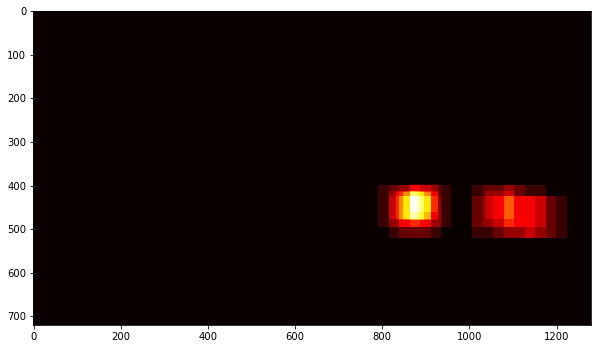

In [18]:
rects = []

ystart = 380
ystop = 500
scale = 1.0
rects.append(find_cars(img, ystart, ystop, scale, svc,
                        X_scale_funct, color_space, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins))
ystart = 416
ystop = 500
scale = 1.0
rects.append(find_cars(img, ystart, ystop, scale, svc,
                        X_scale_funct, color_space, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins))

ystart = 400
ystop = 600
scale = 1.5
rects.append(find_cars(img, ystart, ystop, scale, svc,
                        X_scale_funct, color_space, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins))
ystart = 500
ystop = 700
scale = 2.5
rects.append(find_cars(img, ystart, ystop, scale, svc,
                        X_scale_funct, color_space, orient,
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_size, hist_bins))

rectangles = [item for sublist in rects for item in sublist]

heatmap_img = np.zeros_like(img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Apply threshold to heatmap to remoe false positives

In [19]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

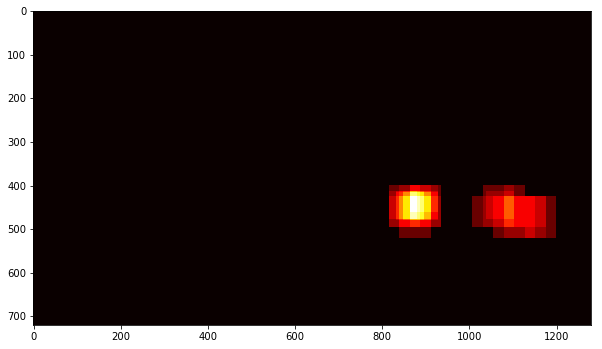

In [20]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Apply scipy labels to heatmap

2 cars found


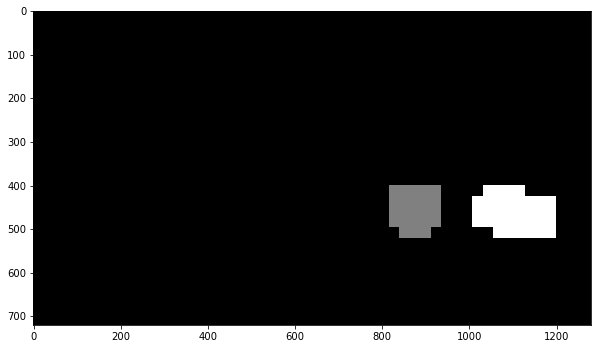

In [21]:
from scipy.ndimage.measurements import label

labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

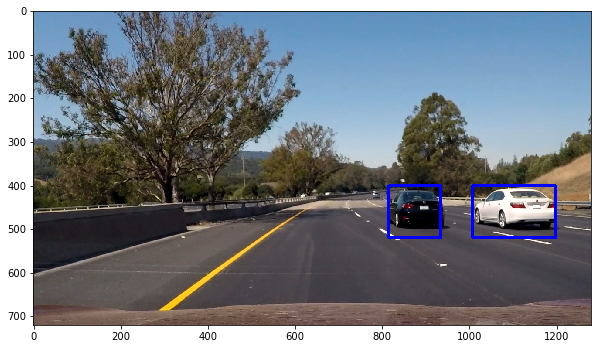

In [22]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

In [23]:
### Apply find_cars on frame image with different params.

In [24]:
def frame_vehicle_detect(img):
    rects = []

    ystart = 380
    ystop = 500
    scale = 1.0
    rects.append(find_cars(img, ystart, ystop, scale, svc,
                            X_scale_funct, color_space, orient,
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size, hist_bins))
    ystart = 416
    ystop = 500
    scale = 1.0
    rects.append(find_cars(img, ystart, ystop, scale, svc,
                            X_scale_funct, color_space, orient,
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size, hist_bins))

    ystart = 400
    ystop = 600
    scale = 1.5
    rects.append(find_cars(img, ystart, ystop, scale, svc,
                            X_scale_funct, color_space, orient,
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size, hist_bins))
    ystart = 500
    ystop = 700
    scale = 2.5
    rects.append(find_cars(img, ystart, ystop, scale, svc,
                            X_scale_funct, color_space, orient,
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_size, hist_bins))

    rectangles = [item for sublist in rects for item in sublist]
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    
    heatmap_img = apply_threshold(heatmap_img, 1)
    
    labels = label(heatmap_img)
    
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

### Detect cars on test images

C:\Users\Vinay\Anaconda3\envs\tf-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


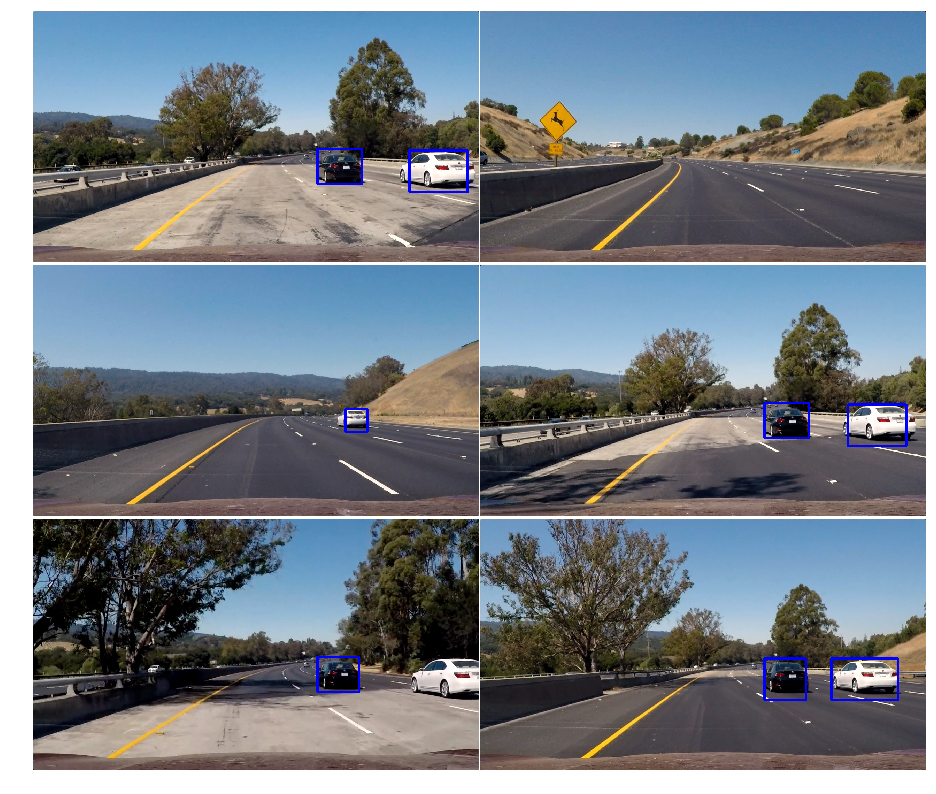

In [25]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(frame_vehicle_detect(mpimg.imread(im)))
    axs[i].axis('off')


### Find cars in project video

In [98]:
from moviepy.editor import VideoFileClip

test_out_file = 'result.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(frame_vehicle_detect)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [25:31<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

Wall time: 25min 32s
